In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
# cluster.scale(12)
# # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/mars4/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39336 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:41266 Dashboard: http://127.0.0.1:39336/status,Cluster Workers: 8 Cores: 56 Memory: 270.19 GB


In [2]:
import numpy as np
import xarray as xr
import qgutils
import os.path as op
import matplotlib as mpl
mpl.rcParams['pcolor.shading'] = 'auto'
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
U = .1
nl = 3
T = 5e5  # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4   # Rossby radius (50km)
Re4 = 1563.
# f0 = 8e-5
beta = .5
N = 256    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = 187

In [4]:
ddir = '/store/CT1/hmg2840/tuchida/msqg-diags/seas-forcing/'
scratch = '/scratch/cnt0024/hmg2840/tuchida/qg-ensemble/'
store = '/store/tuchida/msqg-diags/seas-forcing/ctrl/10percent/Fr-sqrt3_Ekb-2/'
# ddir = '/store/CT1/hmg2840/tuchida/msqg/const-forcing/'

In [6]:
ds = xr.open_dataset(op.join(ddir, 'ctrl/10percent/Fr-sqrt3_Ekb-2/vars000.nc'))
ds

<xarray.Dataset>
Dimensions:  (t: 623, x: 256, y: 256, z: 3)
Coordinates:
  * y        (y) float32 0.0 1.0 2.0 3.0 4.0 ... 251.0 252.0 253.0 254.0 255.0
  * x        (x) float32 0.0 1.0 2.0 3.0 4.0 ... 251.0 252.0 253.0 254.0 255.0
  * z        (z) float32 0.0 1.0 2.0
  * t        (t) float32 0.0 1.0 2.0 3.0 4.0 ... 618.0 619.0 620.0 621.0 622.0
Data variables:
    p        (t, z, y, x) float32 ...
    q        (t, z, y, x) float32 ...
    ptr0     (t, z, y, x) float32 ...
    ptr1     (t, z, y, x) float32 ...

In [6]:
psi = xr.DataArray(qgutils.pad_bc(ds.p.isel(t=-1)), dims=['z','y','x'],
                   coords={'z':ds.z.data,'y':range(-1,N+1),'x':range(-1,N+1)})
# psi_doub = psi.interp({'y':np.arange(-.25,N-.25,.5),'x':np.arange(-.25,N-.25,.5)})
psi_quad = psi.interp({'y':np.arange(-.125,N-.125,.25),'x':np.arange(-.125,N-.125,.25)})
psi_quad

<xarray.DataArray (z: 3, y: 1024, x: 1024)>
array([[[ 2.78135499e-02,  4.46843439e-02,  5.98835653e-02, ...,
         -1.50000895e-06, -5.00002983e-07,  5.00002983e-07],
        [ 4.53451881e-02,  7.28059502e-02,  9.74973489e-02, ...,
         -2.09119958e-06, -6.97066525e-07,  6.97066525e-07],
        [ 6.18660981e-02,  9.92596003e-02,  1.32802539e-01, ...,
         -2.27357486e-06, -7.57858288e-07,  7.57858288e-07],
        ...,
        [-2.97914778e-02, -4.71608135e-02, -6.20384995e-02, ...,
         -2.10694116e-05, -7.02313719e-06,  7.02313719e-06],
        [-9.93049261e-03, -1.57202712e-02, -2.06794998e-02, ...,
         -7.02313719e-06, -2.34104573e-06,  2.34104573e-06],
        [ 9.93049261e-03,  1.57202712e-02,  2.06794998e-02, ...,
          7.02313719e-06,  2.34104573e-06, -2.34104573e-06]],

       [[-7.75847817e-04, -1.12368521e-03, -1.30212811e-03, ...,
         -4.18195654e-06, -1.39398551e-06,  1.39398551e-06],
        [-1.96916130e-03, -2.94747886e-03, -3.59133979e-03, ...,
         -6.96383938e-06, -2.32127979e-06,  2.32127979e-06],
        [-3.83855638e-03, -5.84594269e-03, -7.30167773e-03, ...,
         -9.73963404e-06, -3.24654468e-06,  3.24654468e-06],
...
        [ 1.50039430e-02,  2.35220544e-02,  3.05556484e-02, ...,
         -1.80842774e-05, -6.02809246e-06,  6.02809246e-06],
        [ 5.00131433e-03,  7.84068479e-03,  1.01852161e-02, ...,
         -6.02809246e-06, -2.00936415e-06,  2.00936415e-06],
        [-5.00131433e-03, -7.84068479e-03, -1.01852161e-02, ...,
          6.02809246e-06,  2.00936415e-06, -2.00936415e-06]],

       [[-4.76410770e-03, -7.50359611e-03, -9.80650113e-03, ...,
         -3.92009753e-06, -1.30669918e-06,  1.30669918e-06],
        [-7.86554301e-03, -1.23872363e-02, -1.61869277e-02, ...,
         -6.53392212e-06, -2.17797404e-06,  2.17797404e-06],
        [-1.08923418e-02, -1.71521194e-02, -2.24101134e-02, ...,
         -9.14817295e-06, -3.04939098e-06,  3.04939098e-06],
        ...,
        [ 1.03373551e-02,  1.63178996e-02,  2.13874185e-02, ...,
         -1.77474788e-05, -5.91582625e-06,  5.91582625e-06],
        [ 3.44578503e-03,  5.43929986e-03,  7.12913950e-03, ...,
         -5.91582625e-06, -1.97194208e-06,  1.97194208e-06],
        [-3.44578503e-03, -5.43929986e-03, -7.12913950e-03, ...,
          5.91582625e-06,  1.97194208e-06, -1.97194208e-06]]])
Coordinates:
  * z        (z) float32 0.0 1.0 2.0
  * y        (y) float64 -0.125 0.125 0.375 0.625 ... 254.9 255.1 255.4 255.6
  * x        (x) float64 -0.125 0.125 0.375 0.625 ... 254.9 255.1 255.4 255.6

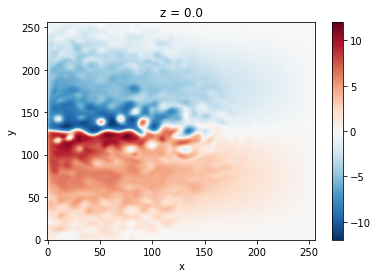

In [13]:
psi_quad.isel(z=0).plot()

In [8]:
Nz, Ny, Nx = psi_quad.shape
p_bas = np.zeros((Nz,Ny+1,Nx+1))
p_bas[:,1:,1:] = psi_quad.data
p_bas[:,0,0] = Ny
p_bas = np.transpose(p_bas, (0,2,1))
# p_bas.astype('f4').tofile(work+'p0-seas%02dpercent_nonperturb_%03d.bas' % (percent,ver))
# p_bas.astype('f4').tofile(work+'p0-seas20percent_nonperturb_%03d.bas' % (ver))
# p_bas.astype('f4').tofile(work+'runs/const-forcing/with-ptrs/control/Fr_sqrt3_Ekb_2/p0_%03d.bas' % (ver))
p_bas.astype('f4').tofile(scratch+'initial-cond/p0_N1024.bas')

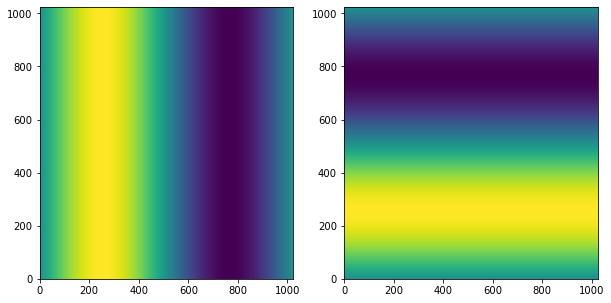

In [10]:
# Delta = 1/N
x = np.linspace(-1.,1.,N*4)
sin = np.sin(2*np.pi*np.linspace(0,1,N*4))

ptr0 = np.zeros((nl,N*4,N*4))
ptr0 += x[np.newaxis,np.newaxis,:]

ptr1 = np.zeros((nl,N*4,N*4))
ptr1 += x[np.newaxis,:,np.newaxis]

ptr2 = np.zeros((nl,N*4,N*4))
ptr2 += sin[np.newaxis,np.newaxis,:]

ptr3 = np.zeros((nl,N*4,N*4))
ptr3 += sin[np.newaxis,:,np.newaxis]

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.pcolormesh(ptr2[0])
ax2.pcolormesh(ptr3[0])

In [12]:
nptr = 4
ptr = np.zeros((nl*nptr,N*4+1,N*4+1))
ptr[:,0,0] = N*4
ptr[0::nptr,1:,1:] = ptr0
ptr[1::nptr,1:,1:] = ptr1
ptr[2::nptr,1:,1:] = ptr2
ptr[3::nptr,1:,1:] = ptr3
ptr = np.transpose(ptr,(0,2,1))
ptr.astype('f4').tofile(scratch+'initial-cond/ptr_init_N1024.bas')
ptr.astype('f4').tofile(scratch+'initial-cond/ptr_relx_N1024.bas')

# Generate perturbed initial condition

In [7]:
ds = xr.open_zarr('/store/tuchida/msom/msqg/spin-up/vars001/')
ds

<xarray.Dataset>
Dimensions:  (XC: 1024, XG: 1024, YC: 1024, YG: 1024, Z: 3, Zp1: 4, time: 312)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XG       (XG) float64 0.0 0.07812 0.1562 0.2344 ... 79.69 79.77 79.84 79.92
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YG       (YG) float64 0.0 0.07812 0.1562 0.2344 ... 79.69 79.77 79.84 79.92
  * Z        (Z) float64 0.03 0.13 0.6
  * Zp1      (Zp1) float64 0.0 0.06 0.2 1.0
    drC      (Zp1) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 308.0 309.0 310.0 311.0
Data variables:
    p        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    ptr0     (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    ptr1     (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    ptr2     (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    ptr3     (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    q        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>

67258
<xarray.DataArray (Z: 3, YC: 1024, XC: 1024)>
dask.array<concatenate, shape=(3, 1024, 1024), dtype=float32, chunksize=(2, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    time     float32 311.0
  * Z        (Z) float64 0.03 0.13 0.6
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96


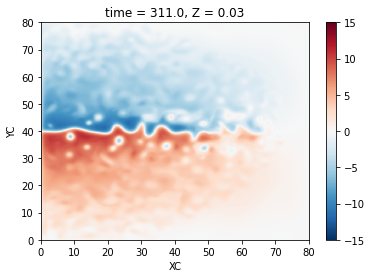

66983
84146
24340
93173
4117
24595
72441
33127
89086
77527
<xarray.DataArray (Z: 3, YC: 1024, XC: 1024)>
dask.array<concatenate, shape=(3, 1024, 1024), dtype=float32, chunksize=(2, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    time     float32 311.0
  * Z        (Z) float64 0.03 0.13 0.6
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96


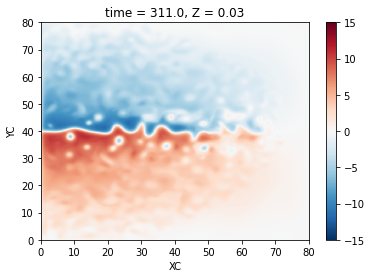

44485
19702
90651
33312
82569
85840
88211
59201
2856
17193
<xarray.DataArray (Z: 3, YC: 1024, XC: 1024)>
dask.array<concatenate, shape=(3, 1024, 1024), dtype=float32, chunksize=(2, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    time     float32 311.0
  * Z        (Z) float64 0.03 0.13 0.6
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96


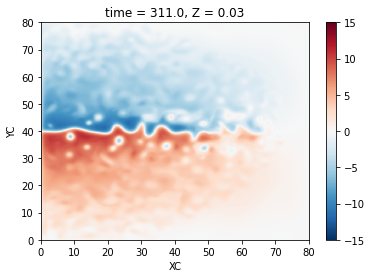

36604
2528
2823
42346
6037
99058
70543
55170
14186
22871
<xarray.DataArray (Z: 3, YC: 1024, XC: 1024)>
dask.array<concatenate, shape=(3, 1024, 1024), dtype=float32, chunksize=(2, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    time     float32 311.0
  * Z        (Z) float64 0.03 0.13 0.6
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96


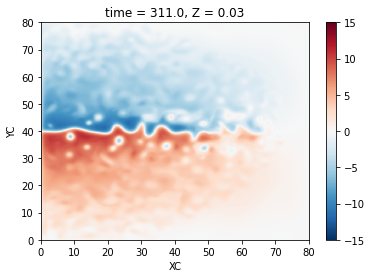

48159
83750
29823
63679
97921
34969
17262
26487
61472
80306
<xarray.DataArray (Z: 3, YC: 1024, XC: 1024)>
dask.array<concatenate, shape=(3, 1024, 1024), dtype=float32, chunksize=(2, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    time     float32 311.0
  * Z        (Z) float64 0.03 0.13 0.6
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96


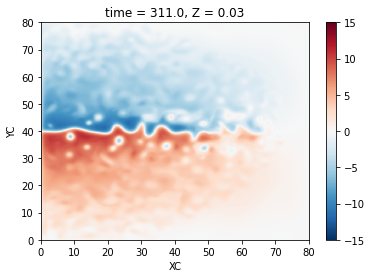

34887
57209
50085
52713
55413
37921
7080
91659
15375
35347
<xarray.DataArray (Z: 3, YC: 1024, XC: 1024)>
dask.array<concatenate, shape=(3, 1024, 1024), dtype=float32, chunksize=(2, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    time     float32 311.0
  * Z        (Z) float64 0.03 0.13 0.6
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96


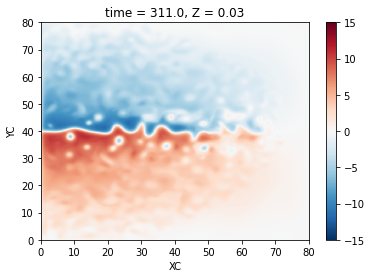

20129
2177
58709
67813
7729
85805
23414
41260
8797
43405
<xarray.DataArray (Z: 3, YC: 1024, XC: 1024)>
dask.array<concatenate, shape=(3, 1024, 1024), dtype=float32, chunksize=(2, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    time     float32 311.0
  * Z        (Z) float64 0.03 0.13 0.6
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96


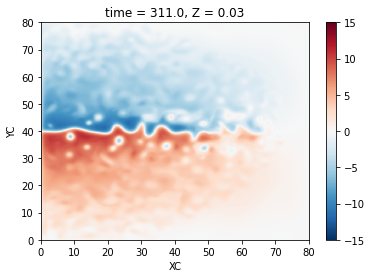

76788
43050
22259
15170
55297
3533
70957
65753
49801
17456
<xarray.DataArray (Z: 3, YC: 1024, XC: 1024)>
dask.array<concatenate, shape=(3, 1024, 1024), dtype=float32, chunksize=(2, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    time     float32 311.0
  * Z        (Z) float64 0.03 0.13 0.6
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96


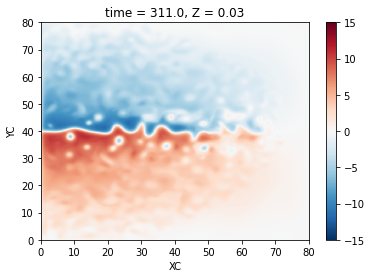

38518
337
62652
16107
1099
4637
34012
41612
31896
48995
<xarray.DataArray (Z: 3, YC: 1024, XC: 1024)>
dask.array<concatenate, shape=(3, 1024, 1024), dtype=float32, chunksize=(2, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    time     float32 311.0
  * Z        (Z) float64 0.03 0.13 0.6
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96


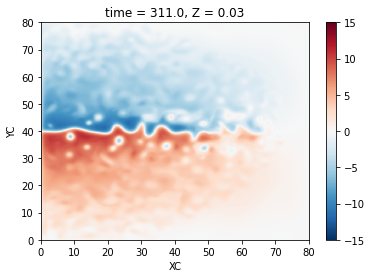

24565
88621
97113
47456
41395
85807
78540
40453
84454
8555
<xarray.DataArray (Z: 3, YC: 1024, XC: 1024)>
dask.array<concatenate, shape=(3, 1024, 1024), dtype=float32, chunksize=(2, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    time     float32 311.0
  * Z        (Z) float64 0.03 0.13 0.6
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96


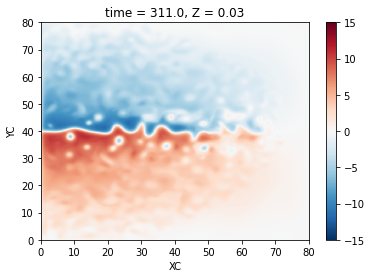

88583
47894
80102
78013
72450
25618
43416
63944
75806


In [29]:
Ns,Ne = (0,100)
xs = 800
ys = 100
ye = 924
percent = 10
for i in range(Ns,Ne):
    j = np.random.randint(0,int(len(ds.XC.isel(XC=slice(None,xs)))*len(ds.YC.isel(YC=slice(xs,ye)))))
    print(j)
    k = 1e-5 * np.random.standard_normal()
    p = ds.p.isel(time=-1,Z=0,XC=slice(None,xs),YC=slice(ys,ye)).load().data.ravel()
    p[j] += k
    psave = xr.concat([xr.concat([xr.concat([xr.concat([
                        xr.DataArray(p.reshape((1,len(ds.YC.isel(YC=slice(ys,ye))),
                                                len(ds.XC.isel(XC=slice(None,xs))))), 
                                     dims=['Z','YC','XC'], 
                                     coords={'Z':np.array([0.03]), 
                                             'YC':ds.YC.isel(YC=slice(ys,ye)).data, 
                                             'XC':ds.XC.isel(XC=slice(None,xs)).data}
                                    ), 
                        ds.p.isel(time=-1,Z=slice(None,1),XC=slice(None,xs),YC=slice(None,ys)).drop(['drF'])
                                                       ], 'YC'),
                                             ds.p.isel(time=-1,Z=slice(None,1),XC=slice(None,xs),YC=slice(ye,None)).drop(['drF'])
                                            ], 'YC'),
                                  ds.p.isel(time=-1,Z=slice(None,1),XC=slice(xs,None)).drop(['drF'])
                                 ], 'XC'),
                       ds.p.isel(time=-1,Z=slice(1,None)).drop(['drF'])
                      ], 'Z')
    if i % 10 == 0:
        print(psave)
        fig, ax = plt.subplots()
        psave.isel(Z=0).plot(ax=ax, vmax=15)
        plt.show()
    
    Nz, Ny, Nx = psave.shape
    p_bas = np.zeros((Nz,Ny+1,Nx+1))
    p_bas[:,1:,1:] = psave.data
    p_bas[:,0,0] = Ny
    p_bas = np.transpose(p_bas, (0,2,1))
    p_bas.astype('f4').tofile(scratch+'initial-cond/psi-perturbed/N1024/p0-seas_%02dpercent_%03d.bas' % (percent,i))

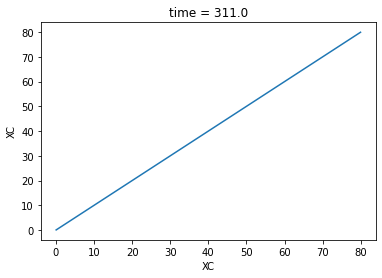

In [30]:
psave.XC.plot()

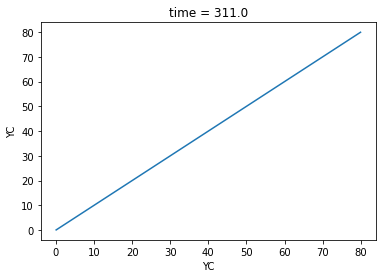

In [31]:
psave.YC.plot()